In [ ]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import ks_2samp, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Create output directory
output_dir = Path("../../Results/Advanced_Analysis/data_drift")
output_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:
# Load event log
log_path = "../../Dataset/BPI Challenge 2017.xes"
log = pm4py.read_xes(log_path)
df = pm4py.convert_to_dataframe(log)

# Ensure timestamp is datetime
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)

# Sort by case and timestamp
df = df.sort_values(['case:concept:name', 'time:timestamp'])

print(f"Loaded {len(df):,} events")
print(f"Number of cases: {df['case:concept:name'].nunique():,}")


Loaded 1,202,267 events
Number of cases: 31,509


In [ ]:
# Extract case-level features
case_data = df.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max'],
    'concept:name': lambda x: list(x),  # Activity sequence
    'case:LoanGoal': 'first',
    'case:ApplicationType': 'first',
    'case:RequestedAmount': 'first'
}).reset_index()

case_data.columns = ['case_id', 'start_time', 'end_time', 'activity_sequence', 
                     'loan_goal', 'app_type', 'requested_amount']

# Calculate case duration (in days)
case_data['duration_days'] = (case_data['end_time'] - case_data['start_time']).dt.total_seconds() / (24 * 3600)

# Calculate case length (activity frequency - total number of activities per case)
case_data['case_length'] = case_data['activity_sequence'].apply(len)

# Classify outcomes based on endpoint activities
def classify_outcome(activities):
    if activities is None or len(activities) == 0:
        return 'Unknown'
    activities_set = set(activities)
    if 'A_Denied' in activities_set:
        return 'Denied'
    if 'A_Cancelled' in activities_set:
        return 'Cancelled'
    if 'A_Pending' in activities_set:
        return 'Pending'
    return 'Other'

case_data['outcome'] = case_data['activity_sequence'].apply(classify_outcome)

# Create monthly time windows based on start_time
case_data['month'] = case_data['start_time'].dt.to_period('M')
case_data['month_str'] = case_data['month'].astype(str)

# Filter to months with sufficient data (at least 100 cases)
month_counts = case_data['month_str'].value_counts()
valid_months = month_counts[month_counts >= 100].index.tolist()
case_data = case_data[case_data['month_str'].isin(valid_months)].copy()

# Sort by month
case_data = case_data.sort_values('start_time')

print(f"Prepared {len(case_data):,} cases")
print(f"Number of months: {case_data['month_str'].nunique()}")
print(f"\nMonths in dataset:")
print(case_data['month_str'].value_counts().sort_index())


Prepared 31,509 cases
Number of months: 12

Months in dataset:
month_str
2016-01    2194
2016-02    2412
2016-03    2454
2016-04    2177
2016-05    2068
2016-06    3001
2016-07    3039
2016-08    3085
2016-09    3042
2016-10    2995
2016-11    2676
2016-12    2366
Name: count, dtype: int64


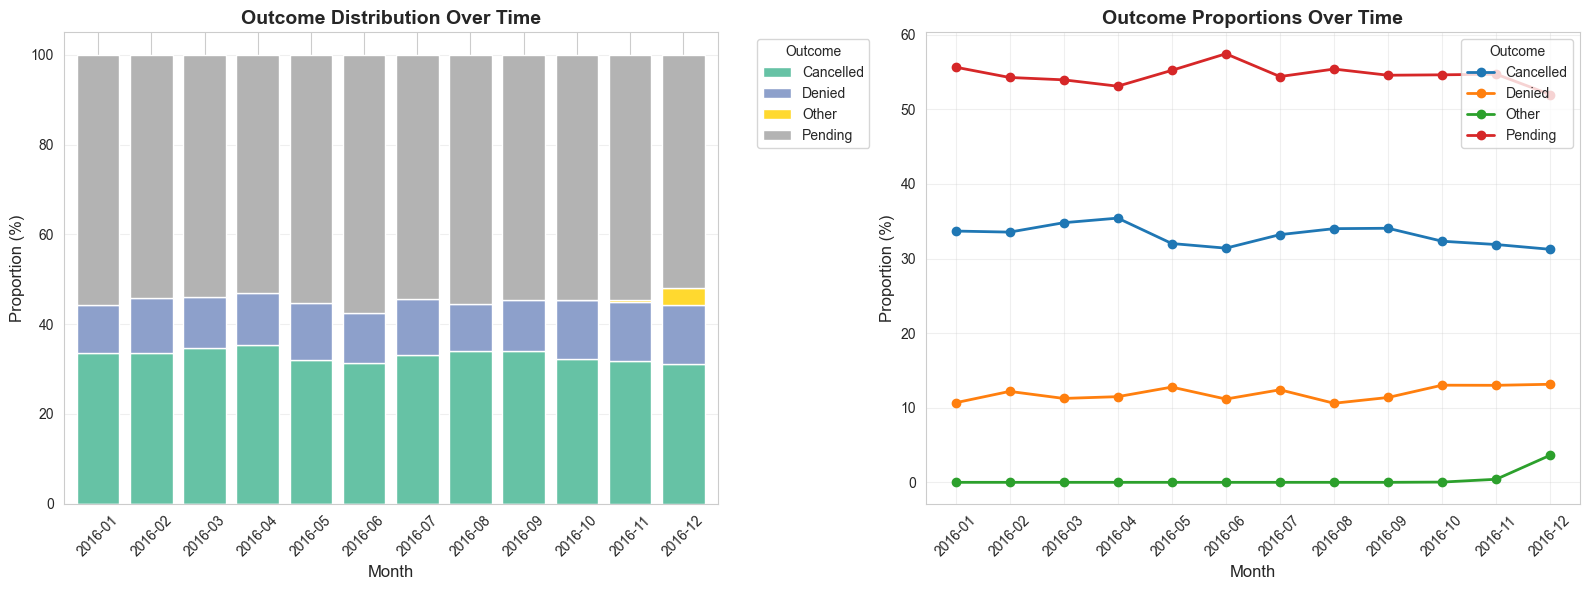

Saved: outcome_distribution.png


In [ ]:
# Distribution visualizations for Outcome (categorical)
outcome_by_month = pd.crosstab(case_data['month_str'], case_data['outcome'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
outcome_by_month.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2', width=0.8)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Proportion (%)', fontsize=12)
axes[0].set_title('Outcome Distribution Over Time', fontsize=14, fontweight='bold')
axes[0].legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Time series of proportions
for outcome in outcome_by_month.columns:
    axes[1].plot(outcome_by_month.index, outcome_by_month[outcome], marker='o', label=outcome, linewidth=2)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Proportion (%)', fontsize=12)
axes[1].set_title('Outcome Proportions Over Time', fontsize=14, fontweight='bold')
axes[1].legend(title='Outcome')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outcome_distribution.png")


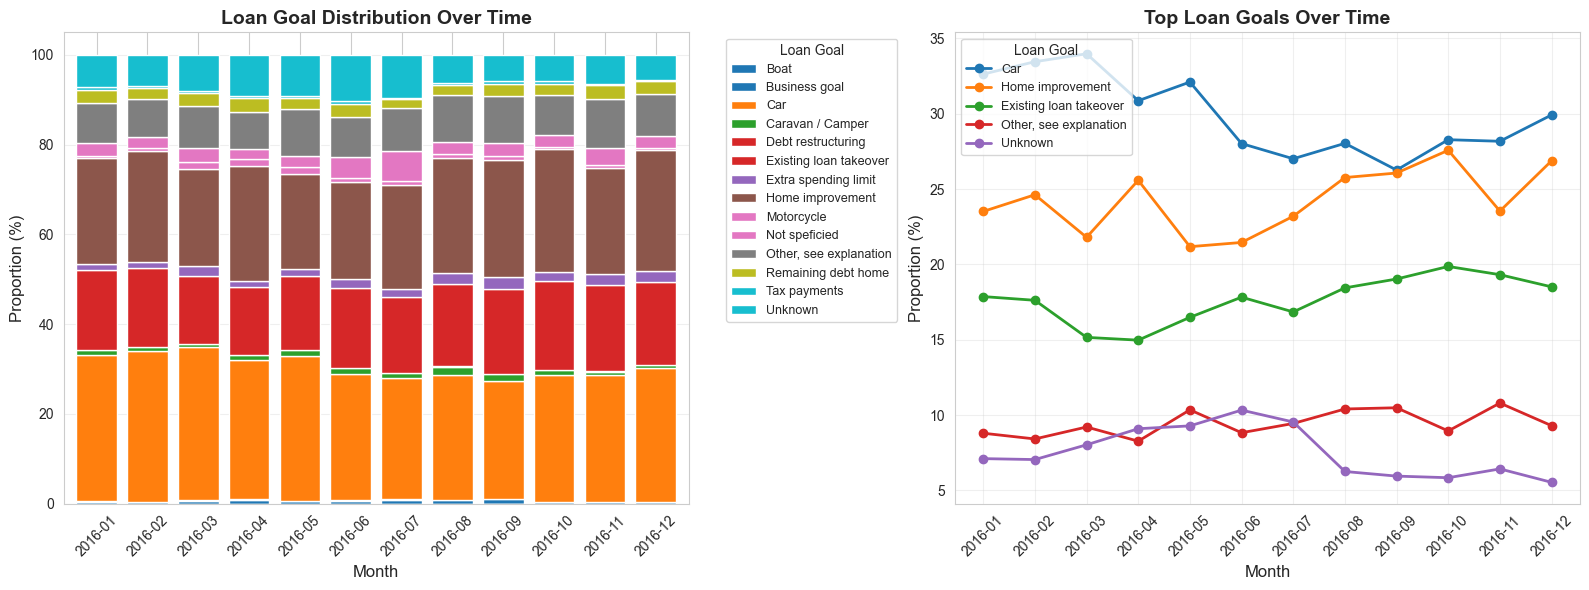

Saved: loan_goal_distribution.png


In [ ]:
# Distribution visualizations for Loan Goal (categorical)
loan_goal_by_month = pd.crosstab(case_data['month_str'], case_data['loan_goal'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
loan_goal_by_month.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab10', width=0.8)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Proportion (%)', fontsize=12)
axes[0].set_title('Loan Goal Distribution Over Time', fontsize=14, fontweight='bold')
axes[0].legend(title='Loan Goal', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Time series for top loan goals
top_goals = loan_goal_by_month.sum().nlargest(5).index
for goal in top_goals:
    if goal in loan_goal_by_month.columns:
        axes[1].plot(loan_goal_by_month.index, loan_goal_by_month[goal], marker='o', label=goal, linewidth=2)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Proportion (%)', fontsize=12)
axes[1].set_title('Top Loan Goals Over Time', fontsize=14, fontweight='bold')
axes[1].legend(title='Loan Goal', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'loan_goal_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: loan_goal_distribution.png")


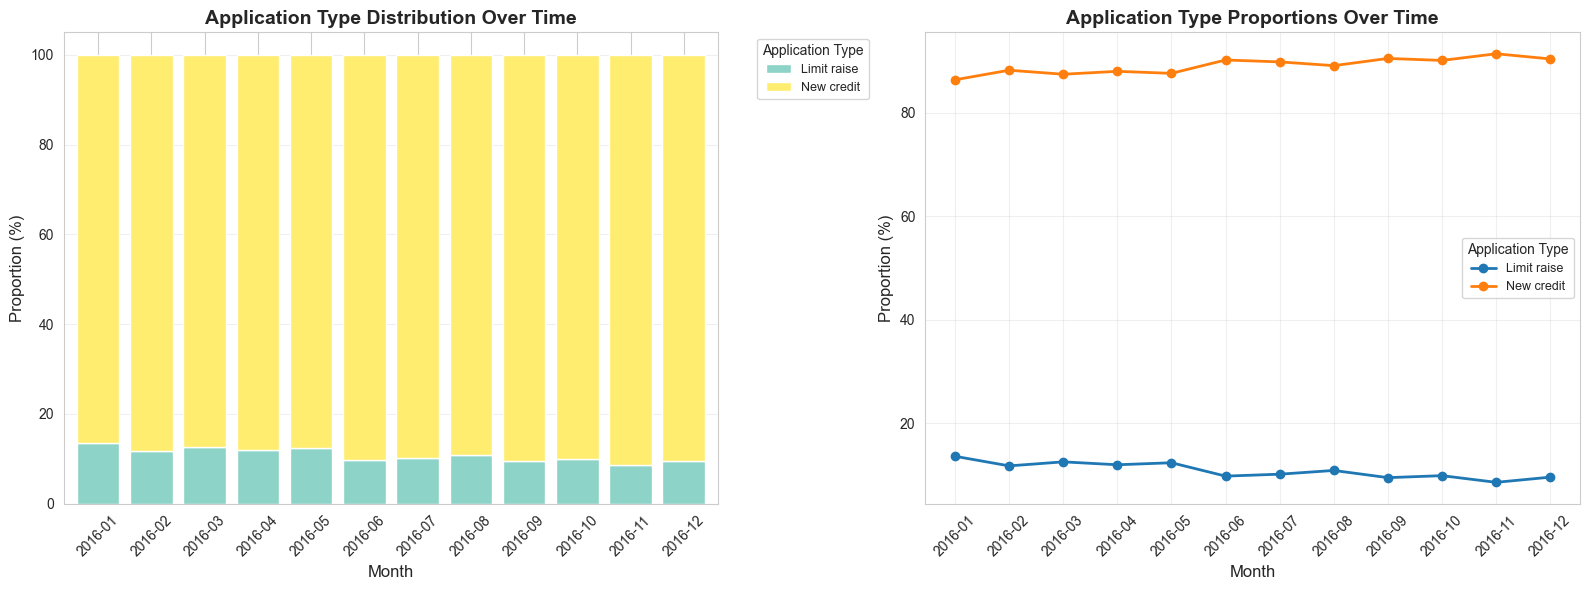

Saved: app_type_distribution.png


In [ ]:
# Distribution visualizations for Application Type (categorical)
app_type_by_month = pd.crosstab(case_data['month_str'], case_data['app_type'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
app_type_by_month.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set3', width=0.8)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Proportion (%)', fontsize=12)
axes[0].set_title('Application Type Distribution Over Time', fontsize=14, fontweight='bold')
axes[0].legend(title='Application Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Time series
for app_type in app_type_by_month.columns:
    axes[1].plot(app_type_by_month.index, app_type_by_month[app_type], marker='o', label=app_type, linewidth=2)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Proportion (%)', fontsize=12)
axes[1].set_title('Application Type Proportions Over Time', fontsize=14, fontweight='bold')
axes[1].legend(title='Application Type', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'app_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: app_type_distribution.png")


In [ ]:
# Statistical Tests for Data Drift Detection
# Compare each month to baseline (first month)

baseline_month = case_data['month_str'].min()
baseline_data = case_data[case_data['month_str'] == baseline_month]
months = sorted(case_data['month_str'].unique())

# Results storage
drift_results = []

print("=== Statistical Tests for Data Drift ===\n")
print(f"Baseline month: {baseline_month}\n")

# Continuous variables: Kolmogorov-Smirnov test
continuous_vars = ['duration_days', 'case_length', 'requested_amount']

for var in continuous_vars:
    baseline_values = baseline_data[var].dropna()
    print(f"\n{var.upper().replace('_', ' ')}:")
    print("-" * 50)
    
    for month in months:
        if month == baseline_month:
            continue
        month_data = case_data[case_data['month_str'] == month][var].dropna()
        
        if len(baseline_values) > 0 and len(month_data) > 0:
            ks_stat, p_value = ks_2samp(baseline_values, month_data)
            significant = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"  {month}: KS-stat={ks_stat:.4f}, p-value={p_value:.4e} {significant}")
            
            drift_results.append({
                'variable': var,
                'month': month,
                'test': 'Kolmogorov-Smirnov',
                'statistic': ks_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })

# Categorical variables: Chi-square test
categorical_vars = ['outcome', 'loan_goal', 'app_type']

for var in categorical_vars:
    baseline_counts = baseline_data[var].value_counts()
    print(f"\n{var.upper().replace('_', ' ')}:")
    print("-" * 50)
    
    for month in months:
        if month == baseline_month:
            continue
        month_data = case_data[case_data['month_str'] == month][var]
        month_counts = month_data.value_counts()
        
        # Create contingency table
        all_categories = set(baseline_counts.index) | set(month_counts.index)
        contingency = pd.DataFrame({
            'baseline': [baseline_counts.get(cat, 0) for cat in all_categories],
            'month': [month_counts.get(cat, 0) for cat in all_categories]
        }, index=list(all_categories))
        
        if contingency.sum().sum() > 0:
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            significant = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"  {month}: Chi2={chi2:.4f}, p-value={p_value:.4e}, dof={dof} {significant}")
            
            drift_results.append({
                'variable': var,
                'month': month,
                'test': 'Chi-square',
                'statistic': chi2,
                'p_value': p_value,
                'significant': p_value < 0.05
            })

# Convert results to DataFrame
drift_df = pd.DataFrame(drift_results)
drift_df.to_csv(output_dir / 'drift_test_results.csv', index=False)
print(f"\n\nSaved drift test results to: drift_test_results.csv")


=== Statistical Tests for Data Drift ===

Baseline month: 2016-01


DURATION DAYS:
--------------------------------------------------
  2016-02: KS-stat=0.0956, p-value=1.3335e-09 ***
  2016-03: KS-stat=0.1224, p-value=1.3623e-15 ***
  2016-04: KS-stat=0.0761, p-value=5.7937e-06 ***
  2016-05: KS-stat=0.0403, p-value=6.0469e-02 
  2016-06: KS-stat=0.0897, p-value=2.5331e-09 ***
  2016-07: KS-stat=0.0935, p-value=3.8547e-10 ***
  2016-08: KS-stat=0.1260, p-value=3.2862e-18 ***
  2016-09: KS-stat=0.1387, p-value=7.4070e-22 ***
  2016-10: KS-stat=0.0756, p-value=9.4938e-07 ***
  2016-11: KS-stat=0.0794, p-value=4.5450e-07 ***
  2016-12: KS-stat=0.1279, p-value=1.1047e-16 ***

CASE LENGTH:
--------------------------------------------------
  2016-02: KS-stat=0.0657, p-value=9.2217e-05 ***
  2016-03: KS-stat=0.0656, p-value=8.7229e-05 ***
  2016-04: KS-stat=0.0580, p-value=1.1961e-03 **
  2016-05: KS-stat=0.0221, p-value=6.6629e-01 
  2016-06: KS-stat=0.0250, p-value=3.9849e-01 
  2016-07: 

=== Summary of Data Drift Tests ===

P-values (significant drift if p < 0.05):
month             2016-02  2016-03  2016-04  2016-05  2016-06  2016-07  \
variable                                                                 
app_type           0.0650   0.2963   0.1150   0.2439   0.0000   0.0001   
case_length        0.0001   0.0001   0.0012   0.6663   0.3985   0.0009   
duration_days      0.0000   0.0000   0.0000   0.0605   0.0000   0.0000   
loan_goal          0.7270   0.0157   0.0010   0.0065   0.0000   0.0000   
outcome            0.2550   0.4991   0.2324   0.0838   0.2158   0.1526   
requested_amount   0.0282   0.0030   0.0011   0.0105   0.0016   0.1175   

month             2016-08  2016-09  2016-10  2016-11  2016-12  
variable                                                       
app_type           0.0030   0.0000   0.0000   0.0000   0.0000  
case_length        0.0000   0.0000   0.0000   0.0007   0.0000  
duration_days      0.0000   0.0000   0.0000   0.0000   0.0000  
loan_goa

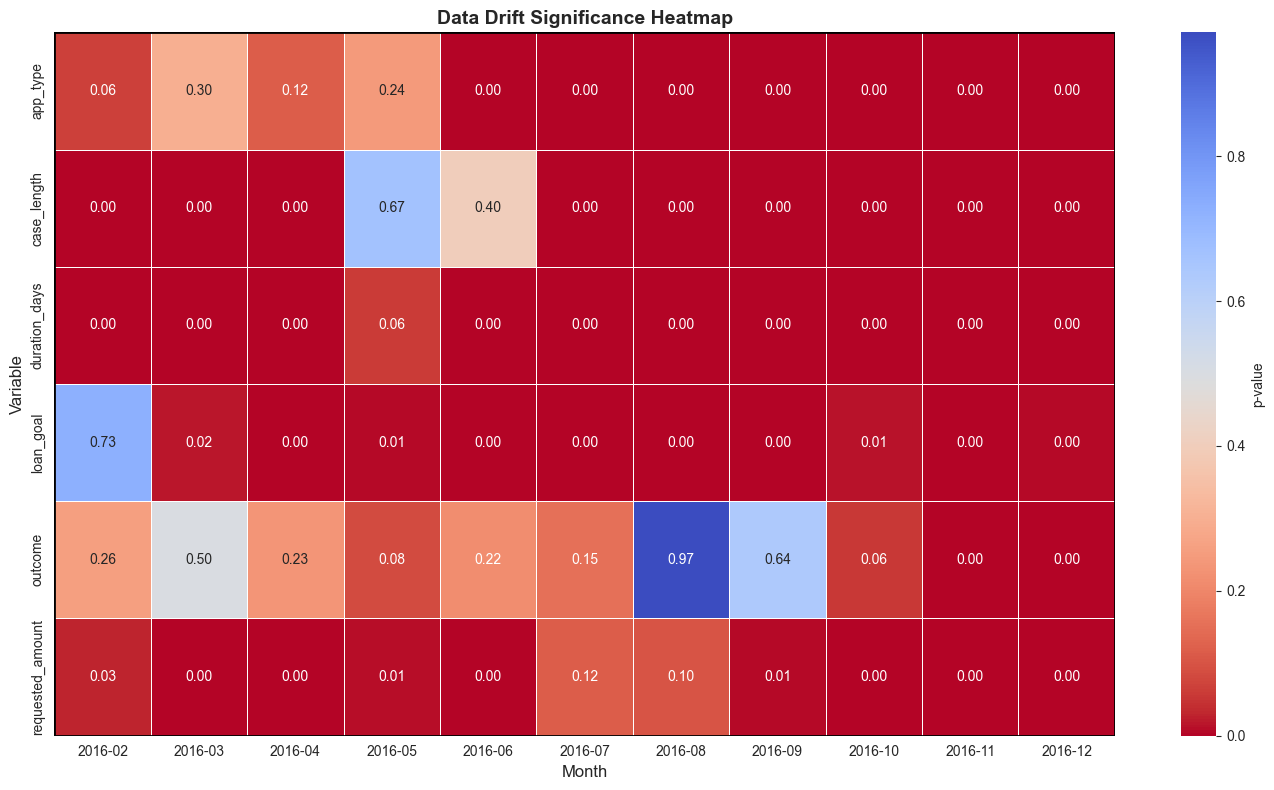

Saved: drift_significance_heatmap.png


In [ ]:
# Summary Table of Drift Results
if len(drift_df) > 0:
    # Create summary pivot table
    summary_pivot = drift_df.pivot_table(
        index='variable',
        columns='month',
        values='p_value',
        aggfunc='first'
    )
    
    # Create significance matrix
    sig_pivot = drift_df.pivot_table(
        index='variable',
        columns='month',
        values='significant',
        aggfunc='first'
    )
    
    print("=== Summary of Data Drift Tests ===\n")
    print("P-values (significant drift if p < 0.05):")
    print(summary_pivot.round(4))
    
    print("\n\nSignificant Drift (True = p < 0.05):")
    print(sig_pivot)
    
    # Count significant drifts per variable
    drift_counts = drift_df.groupby('variable')['significant'].sum()
    print("\n\nNumber of months with significant drift per variable:")
    print(drift_counts)
    
    # Save summary
    summary_pivot.to_csv(output_dir / 'drift_summary_pvalues.csv')
    sig_pivot.to_csv(output_dir / 'drift_summary_significance.csv')
    drift_counts.to_frame('num_significant_drifts').to_csv(output_dir / 'drift_counts.csv')
    
    print(f"\n\nSaved summary tables to output directory")
    
    # Visualization of p-values
    fig, ax = plt.subplots(figsize=(14, 8))
    summary_pivot_plot = summary_pivot.copy()
    summary_pivot_plot = summary_pivot_plot  
    
    sns.heatmap(summary_pivot_plot, annot=True, fmt='.2f', cmap='coolwarm_r', 
               cbar_kws={'label': 'p-value'}, ax=ax, linewidths=0.5)
    ax.axhline(y=0, color='black', linewidth=2)
    ax.axhline(y=len(summary_pivot_plot), color='black', linewidth=2)
    ax.axvline(x=0, color='black', linewidth=2)
    ax.axvline(x=len(summary_pivot_plot.columns), color='black', linewidth=2)
    ax.set_title('Data Drift Significance Heatmap', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Variable', fontsize=12)
    plt.tight_layout()
    plt.savefig(output_dir / 'drift_significance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: drift_significance_heatmap.png")
else:
    print("No drift results to summarize")
